In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks


In [3]:
filepath = 'growth_data1.csv'
filepath2 = 'turb_test_complete.csv'

exp_data = pd.read_csv(filepath)

In [4]:
exp_data['timestamp'] = pd.to_datetime(exp_data['timestamp'])
exp_data['delta_min'] = ((exp_data['timestamp']-exp_data['timestamp'].shift()).dt.total_seconds()/60).fillna(0)
exp_data['total_runtime_min'] = exp_data['delta_min'].cumsum()
exp_data['total_runtime_hour'] = exp_data['total_runtime_min']/60


In [5]:
exp_data.head()

,timestamp,temp,pH,light_prim,light_sec,air,co2,heater_pump,cooler_pump,co2_pump,turb_pump,comments,delta_min,total_runtime_min,total_runtime_hour
0,2025-10-30 16:39:47,20.79,6.62,65.0,376.0,316.25,5.02,0.0,70.0,0.0,0.0,NaN,0.000000,0.000000,0.000000
1,2025-10-30 16:39:48,20.79,6.62,64.0,376.0,316.25,4.91,0.0,70.0,0.0,0.0,start: reactor set to turbidosat|turb set to 1...,0.016667,0.016667,0.000278
2,2025-10-30 16:44:47,20.74,6.65,233.0,828.0,316.25,6.87,0.0,70.0,0.0,0.0,NaN,4.983333,5.000000,0.083333
3,2025-10-30 16:49:48,20.79,6.67,234.0,826.0,316.25,3.92,0.0,70.0,0.0,0.0,NaN,5.016667,10.016667,0.166944
4,2025-10-30 16:54:48,20.79,6.62,233.0,827.0,316.25,5.56,0.0,70.0,0.0,0.0,NaN,5.000000,15.016667,0.250278


In [6]:
peaks_high, props_high = find_peaks(exp_data['light_sec'], height=100, distance=10)

peaks_low, props_low = find_peaks(-exp_data['light_sec'], height=-91.5, distance=10)

# peaks_low
# props_low['peak_heights']

# peaks_high
# props_high['peak_heights']

In [7]:
peaks_low, props_low = find_peaks(-exp_data['light_sec'], height=-91.5, distance=10)

peaks_low
props_low['peak_heights']

array([], dtype=float64)

In [8]:
growth_intervall = []
for i in range(len(peaks_low)):
    growth_data = exp_data.iloc[peaks_high[i]:peaks_low[i]]
    growth_intervall.append(growth_data)

growth_curves = {}
for j in range(len(growth_intervall)):    
    table = growth_intervall[j]
    s = [i * 300 /60 for i in range(len(table['timestamp']))] 
    x = [i for i in range(peaks_high[j],peaks_low[j])]
    y = table['light_sec']
    slope, intercept = np.polyfit(x, y, 1)
    f = np.poly1d((slope, intercept))
    ys = f(x)
    growth_curves[j] = [x, ys, slope, intercept, s]
    
    

In [9]:
len(growth_curves)

0

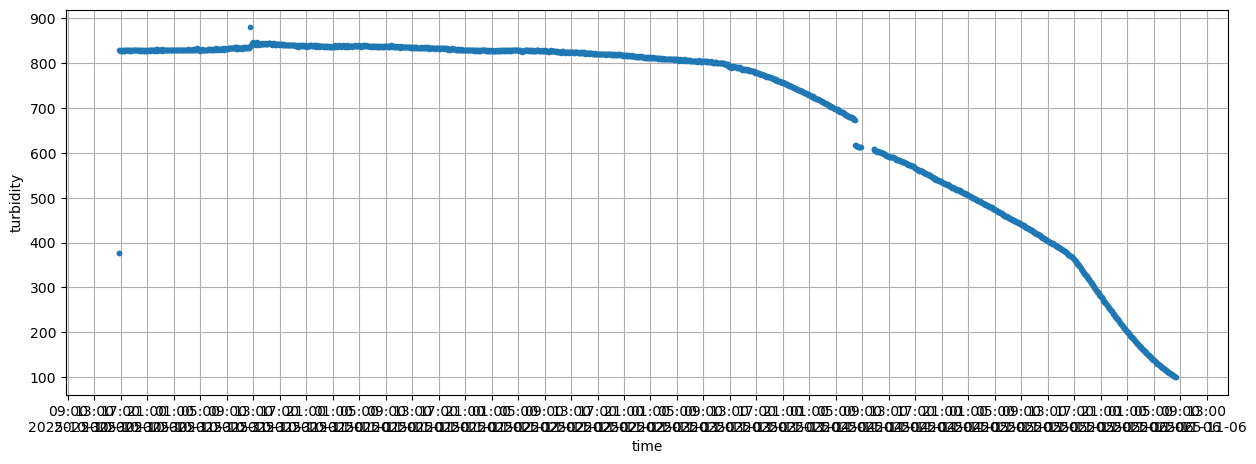

In [10]:
fig, ax  = plt.subplots(figsize=(15,5))

ax.plot(exp_data['timestamp'], exp_data['light_sec'], '.')

# for k in range(len(growth_curves)):
#     ax.plot(exp_data['timestamp'].iloc[growth_curves[k][0]],growth_curves[k][1], 'r')
#     ax.text(exp_data['timestamp'].iloc[growth_curves[k][0][0]], 94, f'slope :{growth_curves[k][2]:.2f}\ninter: {growth_curves[k][3]:.2f}', color='red')
# ax.plot(exp_data['timestamp'].iloc[peaks_high],props_high['peak_heights'], 'rx')
# ax.plot(exp_data['timestamp'].iloc[peaks_low], -props_low['peak_heights'], 'rx')
ax.set_ylabel('turbidity')
ax.set_xlabel('time')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%Y-%m-%d'))
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


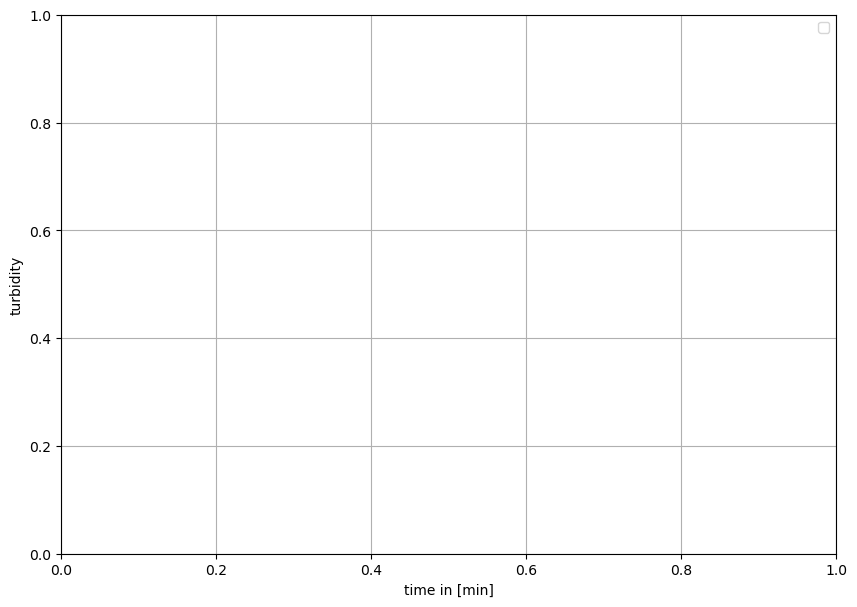

In [11]:
fig, ax  = plt.subplots(figsize=(10,7))

for k in range(len(growth_curves)):
    ax.plot(growth_curves[k][4],growth_curves[k][1], '.', label=f'run {k+1}\nslope: {growth_curves[k][2]:.2f}\ninter: {growth_curves[k][3]:.2f}')
    # ax.text(exp_data['timestamp'].iloc[growth_curves[k][0][5]], 94, f'slope :{growth_curves[k][2]:.2f}\ninter: {growth_curves[k][3]:.2f}', color='red')
ax.set_ylabel('turbidity')
ax.set_xlabel('time in [min]')
plt.legend() 
plt.grid()
plt.show()

In [12]:
exp_data.shape

(1896, 15)

In [13]:
deriv = np.gradient(exp_data['light_sec'][200::20], exp_data['total_runtime_hour'][200::20])

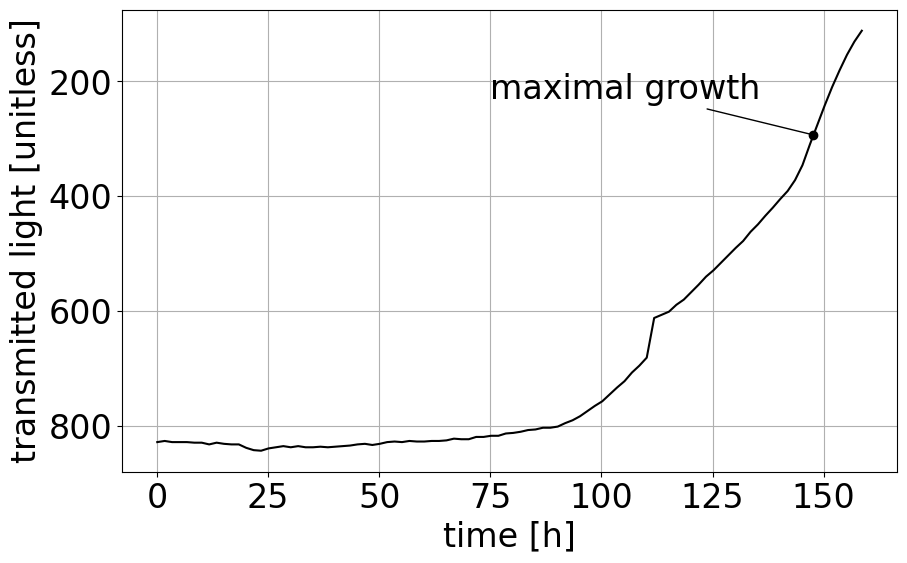

In [23]:
fig, ax = plt.subplots( figsize=(10,6))
# fig.subplots_adjust(right=0.75)

# ax2 = ax.twinx()
# ax3 = ax.twinx()

# ax3.spines.right.set_position(("axes", 1.2))
ax.plot(exp_data['total_runtime_hour'][2::20], exp_data['light_sec'][2::20], 'k')
ax.plot(147.5,293, 'ko')
ax.annotate('maximal growth', (147.5,293), xytext=(75,230), color='k', arrowprops=dict(arrowstyle="-", color='k'), fontsize=24)
# ax[1].plot(exp_data['total_runtime_hour'][200::20], deriv, '.')
# ax2.plot(exp_data['total_runtime_hour'][::20], exp_data['temp'][::20], 'g')
# ax3.plot(exp_data['total_runtime_hour'][::20], exp_data['air'][::20], 'r')
ax.invert_yaxis()
# ax[1].invert_yaxis()
ax.set_ylabel('transmitted light [unitless]', fontsize=24)
ax.set_xlabel('time [h]', fontsize=24)
# ax.set_xlim(140,161)
# ax.set_ylim(500,90)
# ax2.set_ylim(10,30)
# ax3.set_ylim(0,500)
# ax2.set_ylabel('temperature [°C]', color='g')
# ax3.set_ylabel('pH', color='r')
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
plt.grid()
plt.show()

In [15]:
poi = exp_data[exp_data['total_runtime_hour'] > 140]

In [16]:
deriv = np.gradient(poi['light_sec'], poi['total_runtime_hour'])
peaks_low, props_low = find_peaks(-deriv, height=25, distance=2)


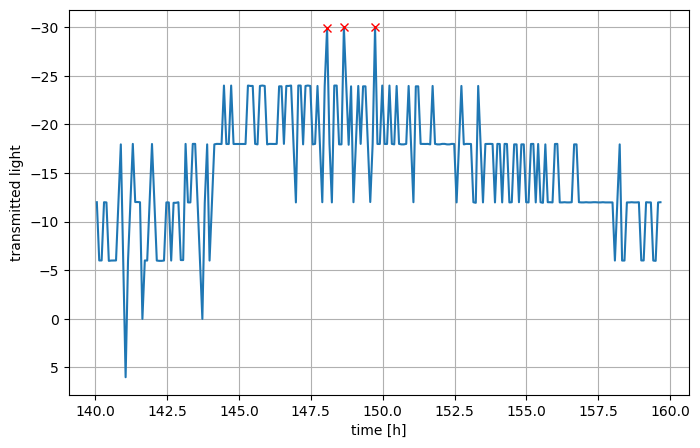

In [17]:
fig, ax = plt.subplots( figsize=(8,5))

ax.plot(poi['total_runtime_hour'], deriv)
ax.plot(poi['total_runtime_hour'].iloc[peaks_low],-props_low['peak_heights'], 'rx')

ax.set_ylabel('transmitted light')
ax.set_xlabel('time [h]')
ax.invert_yaxis()
# ax.set_xlim(140,161)
# ax.set_ylim(500,90)

plt.grid()
plt.show()

In [18]:
poi[(poi['total_runtime_hour'] > 147) & (poi['total_runtime_hour'] < 148)]

,timestamp,temp,pH,light_prim,light_sec,air,co2,heater_pump,cooler_pump,co2_pump,turb_pump,comments,delta_min,total_runtime_min,total_runtime_hour
1744,2025-11-05 19:43:45,21.03,8.13,232.0,308.0,271.28,3.92,0.0,100.0,100.0,0.0,NaN,5.016667,8823.966667,147.066111
1745,2025-11-05 19:48:45,21.02,8.29,232.0,305.0,271.28,6.00,0.0,100.0,100.0,0.0,NaN,5.000000,8828.966667,147.149444
1746,2025-11-05 19:53:45,20.94,8.16,232.0,304.0,272.42,3.25,0.0,90.0,100.0,0.0,NaN,5.000000,8833.966667,147.232778
1747,2025-11-05 19:58:46,20.98,8.16,232.0,302.0,271.28,5.24,0.0,90.0,100.0,0.0,NaN,5.016667,8838.983333,147.316389
1748,2025-11-05 20:03:46,21.02,8.20,232.0,300.0,271.28,3.03,0.0,100.0,100.0,0.0,NaN,5.000000,8843.983333,147.399722
1749,2025-11-05 20:08:46,20.95,8.13,232.0,298.0,271.28,4.47,0.0,90.0,100.0,0.0,NaN,5.000000,8848.983333,147.483056
1750,2025-11-05 20:13:47,20.94,8.26,232.0,296.0,271.28,3.03,0.0,90.0,100.0,0.0,NaN,5.016667,8854.000000,147.566667
1751,2025-11-05 20:18:47,21.02,8.13,232.0,295.0,271.28,3.81,0.0,100.0,100.0,0.0,NaN,5.000000,8859.000000,147.650000
1752,2025-11-05 20:23:47,21.01,8.29,232.0,293.0,270.15,6.00,0.0,90.0,100.0,0.0,NaN,5.000000,8864.000000,147.733333
1753,2025-11-05 20:28:48,20.97,8.16,232.0,291.0,271.28,3.25,0.0,90.0,100.0,0.0,NaN,5.016667,8869.016667,147.816944


In [19]:
poi.iloc[peaks_low]

,timestamp,temp,pH,light_prim,light_sec,air,co2,heater_pump,cooler_pump,co2_pump,turb_pump,comments,delta_min,total_runtime_min,total_runtime_hour
1756,2025-11-05 20:43:49,20.98,8.16,232.0,286.0,270.15,4.47,0.0,90.0,100.0,0.0,NaN,5.016667,8884.033333,148.067222
1763,2025-11-05 21:18:51,21.02,8.16,232.0,275.0,270.15,4.47,0.0,100.0,100.0,0.0,NaN,5.000000,8919.066667,148.651111
1776,2025-11-05 22:23:55,20.94,8.26,232.0,252.0,269.03,3.03,0.0,90.0,100.0,0.0,NaN,5.000000,8984.133333,149.735556


In [20]:
len(np.gradient(exp_data['light_sec']))

# len(exp_data['light_sec'])
# exp_data['light_sec']

1896

## Other stuff


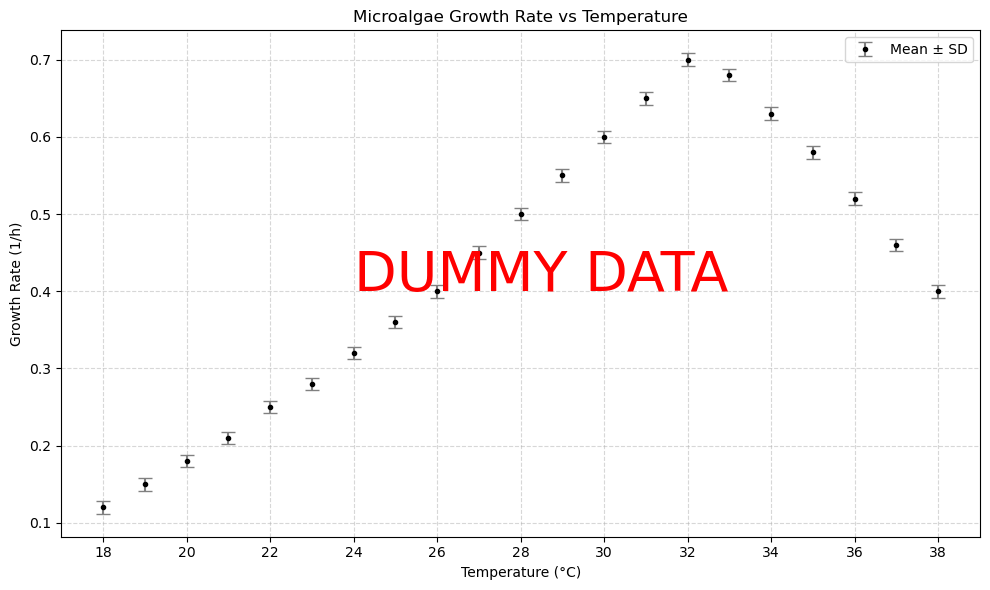

In [21]:
# Temperature range
temperature = np.arange(18, 39, 1)

# Dummy growth rates for three repetitions (peak at 32 °C)
growth_rep1 = np.array([0.12, 0.15, 0.18, 0.21, 0.25, 0.28, 0.32, 0.36, 0.40, 0.45,
                        0.50, 0.55, 0.60, 0.65, 0.70, 0.68, 0.63, 0.58, 0.52, 0.46, 0.40])
growth_rep2 = np.array([0.11, 0.14, 0.17, 0.22, 0.24, 0.27, 0.31, 0.35, 0.39, 0.44,
                        0.49, 0.54, 0.59, 0.64, 0.71, 0.67, 0.64, 0.57, 0.51, 0.45, 0.39])
growth_rep3 = np.array([0.13, 0.16, 0.19, 0.20, 0.26, 0.29, 0.33, 0.37, 0.41, 0.46,
                        0.51, 0.56, 0.61, 0.66, 0.69, 0.69, 0.62, 0.59, 0.53, 0.47, 0.41])

# Calculate mean and standard deviation
growth_mean = np.mean([growth_rep1, growth_rep2, growth_rep3], axis=0)
growth_std = np.std([growth_rep1, growth_rep2, growth_rep3], axis=0)

# Create scatter plot with error bars
plt.figure(figsize=(10, 6))
# plt.scatter(temperature, growth_rep1, color='blue', alpha=0.6, label='Rep 1')
# plt.scatter(temperature, growth_rep2, color='green', alpha=0.6, label='Rep 2')
# plt.scatter(temperature, growth_rep3, color='red', alpha=0.6, label='Rep 3')
plt.text(24, 0.4, 'DUMMY DATA', color='red', size='40')
plt.errorbar(temperature, growth_mean, yerr=growth_std, markersize=3,fmt='o', capsize=5, color='black', ecolor='gray', label='Mean ± SD')
plt.title("Microalgae Growth Rate vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Growth Rate (1/h)")
plt.xticks(np.arange(18, 39, 2))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
